# 54.11 Project. Анализ результатов A/B-теста
## Легенда
### Туристическая компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы.
### Стоимость туров:
#### Таиланд — 100000 рублей;
#### Турция — 60000 рублей;
#### Мальдивы — 200000 рублей;
#### Санкт-Петербург — 10000 рублей;
#### Камчатка — 150000 рублей.
### Проверьте, какая из страниц приносит больше покупок.

## Задачи:
### 1. Провести первичный анализ датасета.
#### - привести столбцы к корректным типам данных;
#### - убедиться, что данные по обеим группам представлены за одинаковый период (визуализировать);
#### - проверить корректность распределения участников теста;
#### - проверить различие в группах;
#### - проверить пересечение аудитории в группах;
#### - определить по группам ряд показателей (количество пользователей, количество покупок, выручку, конверсию, средний чек);
#### - посмотреть, как распределяются суммы покупок (здесь необходимо повизуализировать);
#### - сделать первичные выводы.
### 2. Рассчитайте кумулятивные метрики:
#### - постройте график конверсии в группах по дням;
#### - постройте график среднего чека в группах по дням;
#### - постройте график кумулятивных метрик по конверсии и по среднему чеку;
#### - сделайте выводы.
### 3. Проведите статистическую проверку гипотез:
#### - о равенстве конверсии;
#### - о равенстве выручки;
#### - о равенстве средних чеков по дням.
### 4. Сделайте вывод.

## Шаг 1. Первичный анализ датасета

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
df = pd.read_csv('data/sda_3.0_54_ab_data.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df['date'].describe() # начало и конец наблюдений
df['group'].value_counts() # количество посещений в группах А и В

group
B    147276
A    147202
Name: count, dtype: int64

- проверим разницу в процентовом выражении между группами (не должна быть больше 1%)

In [100]:
a_count = 147202
b_count = 147276
print(round(100*(a_count - b_count)/a_count, 2), '%') 

-0.05 %


- определение пользователей, оказавшихся в обеих группах

In [101]:
# создание фреймов с группами А и В
group_A = df[df['group'] == 'A']
group_B = df[df['group'] == 'B']

# Соединяем оба фрейма данных с индикатором присутствия (both - user присутствует в обоих группах, left_only или right_only - в одной из групп, соотвественно группа A и группа B)
full_user = group_A.merge(group_B, on='user_id', how='outer', indicator=True)
print('Количество пересечений: ', full_user['user_id'][full_user['_merge'] == 'both'].count())

Количество пересечений:  1895


- исключение пользователей, оказавшихся в обеих группах

In [102]:
# Переопределяем наши группы с фильтром
group_A_new = full_user[full_user['_merge'] == 'left_only']
group_B_new = full_user[full_user['_merge'] == 'right_only']

# количество посещений сайта в группах А и В после исключения пользователей
print('Группа А:', group_A_new['user_id'].count())
print('Группа В:', group_B_new['user_id'].count())

# разница в количестве сессий
print(round(100*(145307 - 145381)/145307, 2), '%') 

Группа А: 145307
Группа В: 145381
-0.05 %


- собрать показатели конверсии и среднего чека по каждой группе

In [103]:
group_A_new = group_A_new[['user_id', 'date_x', 'group_x', 'purchase_x', 'price_x']]
group_A_new.rename(columns={'date_x':'date', 'group_x': 'group', 'purchase_x': 'purchase', 'price_x':'price'}, inplace=True)
group_A_new.head()

,user_id,date,group,purchase,price
2,630002,2021-01-19,A,0.0,0.0
7,630008,2021-01-11,A,0.0,0.0
8,630009,2021-01-05,A,1.0,100000.0
10,630011,2021-01-24,A,0.0,0.0
11,630013,2021-01-13,A,1.0,100000.0


In [104]:
group_B_new = group_B_new[['user_id', 'date_y', 'group_y', 'purchase_y', 'price_y']]
group_B_new.rename(columns={'date_y':'date', 'group_y': 'group', 'purchase_y': 'purchase', 'price_y':'price'}, inplace=True)
group_B_new.head()

,user_id,date,group,purchase,price
0,630000,2021-01-19,B,0.0,0.0
1,630001,2021-01-16,B,1.0,200000.0
3,630003,2021-01-12,B,0.0,0.0
4,630004,2021-01-18,B,0.0,0.0
5,630005,2021-01-17,B,1.0,10000.0


In [105]:
# объединяем две таблицы в одну
df_new = pd.concat([group_A_new, group_B_new])
df_new

,user_id,date,group,purchase,price
2,630002,2021-01-19,A,0.0,0.0
7,630008,2021-01-11,A,0.0,0.0
8,630009,2021-01-05,A,1.0,100000.0
10,630011,2021-01-24,A,0.0,0.0
11,630013,2021-01-13,A,1.0,100000.0
...,...,...,...,...,...
292570,945986,2021-01-13,B,0.0,0.0
292571,945987,2021-01-15,B,1.0,100000.0
292573,945989,2021-01-10,B,1.0,150000.0
292579,945996,2021-01-09,B,0.0,0.0


In [106]:
# построим сводную таблицу для подсчета конверсии и среднего чека
df_piv = df_new.groupby(['group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index()
df_piv

,group,user_id,purchase,price
0,A,145307,17487.0,1.417780e+09
1,B,145381,17290.0,1.533010e+09


In [107]:
# считаем конверсию и средний чек
df_piv['conversion'] = df_piv['purchase'] / df_piv['user_id'] * 100
df_piv['average_bill'] = df_piv['price'] / df_piv['purchase']
df_piv

,group,user_id,purchase,price,conversion,average_bill
0,A,145307,17487.0,1.417780e+09,12.034520,81076.228055
1,B,145381,17290.0,1.533010e+09,11.892888,88664.545980


- построим гистограммы с выручкой двух групп А и В

In [108]:
df_a = df_new[(df_new['group'] == 'A')&(df_new['price'] > 0)]
df_b = df_new[(df_new['group'] == 'B')&(df_new['price'] > 0)]

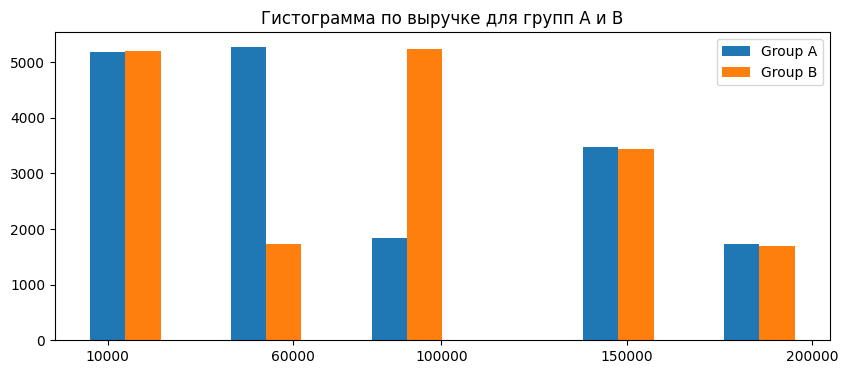

In [109]:
plt.figure(figsize=(10, 4))
plt.hist(df_a['price'], label='Group A', rwidth=0.5, align='left')
plt.hist(df_b['price'], label='Group B', rwidth=0.5, align='mid')
plt.title('Гистограмма по выручке для групп A и B')
x_ticks = [10000, 60000, 100000, 150000, 200000]
plt.xticks(ticks=x_ticks)
plt.legend()
plt.show()

## Шаг 2. Расчет куммулятивных метрик

- создание куммулятивной таблицы

In [110]:
# объединяем данные в отдельный датафрейм для создания кумулятивной таблицы
df_piv_cumm = df_new.groupby(['date','group']).agg(
    {'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}
).reset_index()
df_piv_cumm.head()

,date,group,user_id,purchase,price
0,2021-01-02,A,2854,359.0,29410000.0
1,2021-01-02,B,2861,345.0,29660000.0
2,2021-01-03,A,6596,748.0,62000000.0
3,2021-01-03,B,6619,754.0,65960000.0
4,2021-01-04,A,6566,799.0,64250000.0


In [111]:
# разделяем данные по группам
df_piv_a = df_piv_cumm[df_piv_cumm['group'] == 'A']
df_piv_b = df_piv_cumm[df_piv_cumm['group'] == 'B']

In [112]:
# создаем функцию cummulative_table
def cummulative_table(data): 
    df_cumm = [] 
    for i in data['date'].values: 
        out = data[data['date'] <= i].groupby('group')\
               .agg({'date':'max', 'user_id':'sum', 'purchase':'sum', 'price':'sum'})
        df_cumm.append(out) 
    return pd.concat(df_cumm).reset_index() 

In [113]:
# кумулятивные данные для группы А
cumm_a = cummulative_table(df_piv_a)
cumm_a['conversion, %'] = round(100 * cumm_a['purchase'] / cumm_a['user_id'], 2)
cumm_a['average_bill'] = round(cumm_a['price'] / cumm_a['purchase'], 2)
cumm_a.head()

,group,date,user_id,purchase,price,"conversion, %",average_bill
0,A,2021-01-02,2854,359.0,29410000.0,12.58,81922.01
1,A,2021-01-03,9450,1107.0,91410000.0,11.71,82574.53
2,A,2021-01-04,16016,1906.0,155660000.0,11.90,81668.42
3,A,2021-01-05,22449,2696.0,220210000.0,12.01,81680.27
4,A,2021-01-06,29055,3460.0,283620000.0,11.91,81971.10


In [114]:
# кумулятивные данные для группы В
cumm_b = cummulative_table(df_piv_b)
cumm_b['conversion, %'] = round(100 * cumm_b['purchase'] / cumm_b['user_id'], 2)
cumm_b['average_bill'] = round(cumm_b['price'] / cumm_b['purchase'], 2)
cumm_b.head()

,group,date,user_id,purchase,price,"conversion, %",average_bill
0,B,2021-01-02,2861,345.0,29660000.0,12.06,85971.01
1,B,2021-01-03,9480,1099.0,95620000.0,11.59,87006.37
2,B,2021-01-04,16016,1863.0,163650000.0,11.63,87842.19
3,B,2021-01-05,22527,2612.0,227200000.0,11.59,86983.15
4,B,2021-01-06,29278,3450.0,302220000.0,11.78,87600.00


In [115]:
# Какая суммарная выручка была в группе А на 15 января?
cumm_a[(cumm_a['group'] == 'A')&(cumm_a['date'] == '2021-01-15')]

,group,date,user_id,purchase,price,"conversion, %",average_bill
13,A,2021-01-15,88660,10593.0,865120000.0,11.95,81669.03


In [116]:
# Какая кумулятивная конверсия была в группе B на 20 января?
cumm_b[(cumm_b['group'] == 'B')&(cumm_b['date'] == '2021-01-20')]

,group,date,user_id,purchase,price,"conversion, %",average_bill
18,B,2021-01-20,121857,14496.0,1.286900e+09,11.9,88776.21


In [117]:
# Какой кумулятивный средний чек был в группе А на 12 января?
cumm_a[(cumm_a['group'] == 'A')&(cumm_a['date'] == '2021-01-12')]

,group,date,user_id,purchase,price,"conversion, %",average_bill
10,A,2021-01-12,68852,8198.0,668070000.0,11.91,81491.83


- построение графика кумулятивного среднего чека по дням

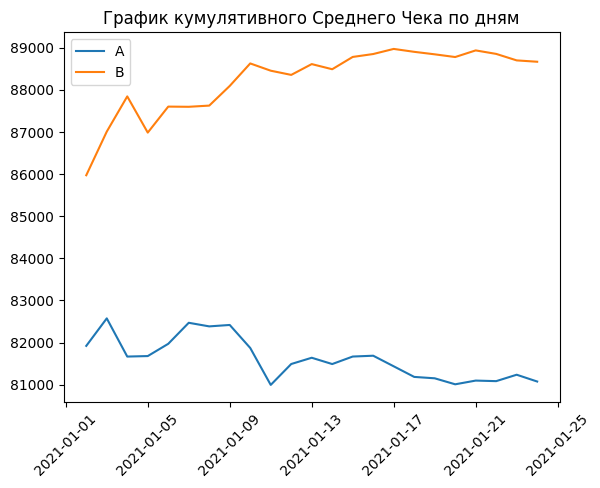

In [118]:
plt.plot(cumm_a['date'], cumm_a['average_bill'],  label='A')
plt.plot(cumm_b['date'], cumm_b['average_bill'], label='B')
plt.title('График кумулятивного Среднего Чека по дням')
plt.xticks(rotation=45)
plt.legend() 
plt.show() 

- построение графика кумулятивной конверсии

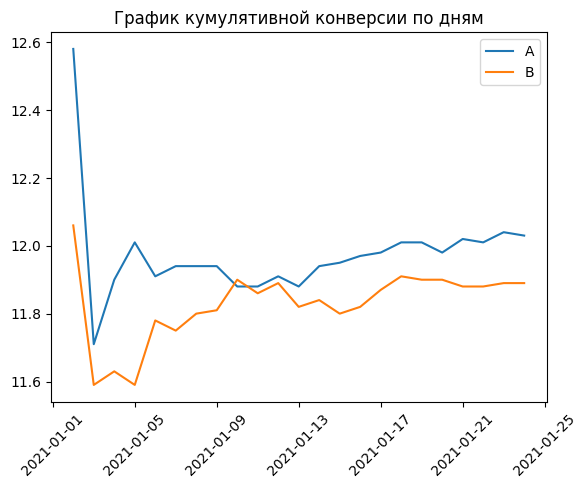

In [119]:
plt.plot(cumm_a['date'], cumm_a['conversion, %'],  label='A')
plt.plot(cumm_b['date'], cumm_b['conversion, %'], label='B')
plt.title('График кумулятивной конверсии по дням')
plt.xticks(rotation=45)
plt.legend() 
plt.show() 

## Шаг 3. Статистическая проверка гипотез

- проведение распределения показателей конверсии в группах (не кумулятивные таблицы)

In [120]:
# ??????? дополняем сводную таблицу с кумулятивными данными по дням
df_piv_cumm['conversion'] = round(df_piv_cumm['purchase'] / df_piv_cumm['user_id'], 2)
df_piv_cumm['average_bill'] = round(df_piv_cumm['price'] / df_piv_cumm['purchase'], 2)
df_piv_cumm.head()

,date,group,user_id,purchase,price,conversion,average_bill
0,2021-01-02,A,2854,359.0,29410000.0,0.13,81922.01
1,2021-01-02,B,2861,345.0,29660000.0,0.12,85971.01
2,2021-01-03,A,6596,748.0,62000000.0,0.11,82887.70
3,2021-01-03,B,6619,754.0,65960000.0,0.11,87480.11
4,2021-01-04,A,6566,799.0,64250000.0,0.12,80413.02


In [121]:
# строим сводную для распределения конверсии по дням
df_piv_daily = df_new.groupby(['date', 'group']).agg(
    {'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}
    ).reset_index()

# найдем показатели конверсии
df_piv_daily['conversion'] = round(df_piv_daily['purchase'] / df_piv_daily['user_id'], 2)
df_piv_daily['average_bill'] = round(df_piv_daily['price'] / df_piv_daily['purchase'], 2)
df_piv_daily.head()

,date,group,user_id,purchase,price,conversion,average_bill
0,2021-01-02,A,2854,359.0,29410000.0,0.13,81922.01
1,2021-01-02,B,2861,345.0,29660000.0,0.12,85971.01
2,2021-01-03,A,6596,748.0,62000000.0,0.11,82887.70
3,2021-01-03,B,6619,754.0,65960000.0,0.11,87480.11
4,2021-01-04,A,6566,799.0,64250000.0,0.12,80413.02


<Axes: >

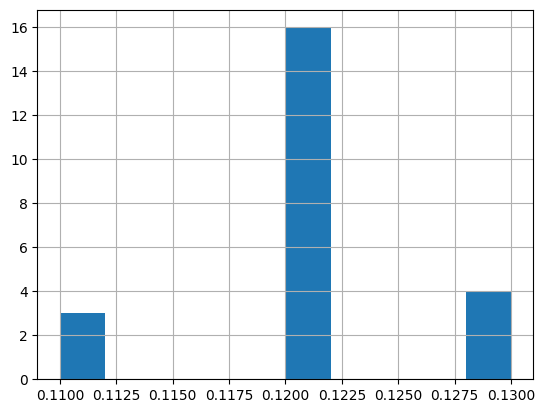

In [122]:
# построим график конверсий для группы А
df_piv_daily[df_piv_daily['group'] == 'A']['conversion'].hist()

<Axes: >

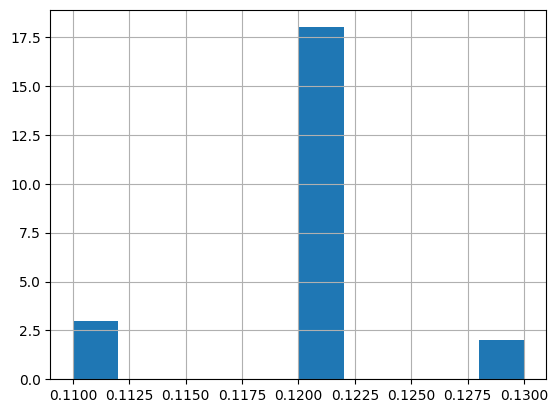

In [123]:
# построим график конверсий для группы В
df_piv_daily[df_piv_daily['group'] == 'B']['conversion'].hist()

- проверка гипотезы о равенстве конверсии при помощи z-теста (так как распределение выглядит нормальным)

#### Нулевая гипотеза: конверсии обеих групп равны
#### Альтернативная гипотеза: конверсии обеих групп не равны

In [124]:
a = 0.05

x_a = 17487
x_b = 17290

n_a = 145307
n_b = 145381

p_a = x_a / n_a
p_b = x_b / n_b
diff = p_a - p_b

p = (x_a + x_b) / (n_a + n_b)

z = diff / math.sqrt(p * (1-p) * (1/n_a + 1/n_b))

distr = stats.norm(0,1) # зададим нормальное стандартное распределение

p_value = (1 - distr.cdf(abs(z))) * 2
print(p_value)

p_value < a

0.23940749849829834


np.False_

#### ВЫВОД: P-value больше принятого уровня значимости, следовательно, статистически значимая разница между конверсиями отсутствует.

- проверка различия в стоимости заказов между группами

#### Нулевая гипотеза: Стоимости заказов равны
#### Альтернативная гипотеза: Стоимости заказов не равны

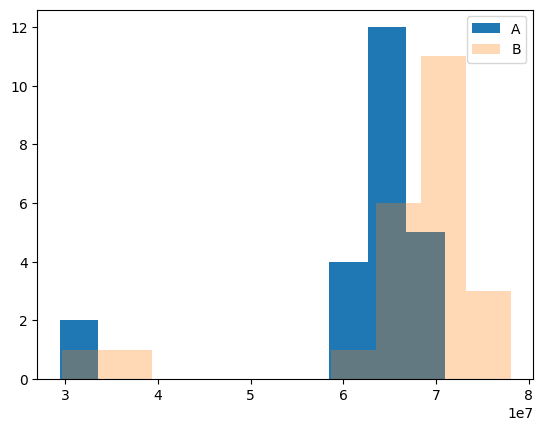

In [125]:
plt.hist(df_piv_daily[(df_piv_daily['group'] == 'A') & (df_piv_daily['purchase'] > 0)]['price'], label='A')
plt.hist(df_piv_daily[(df_piv_daily['group'] == 'B') & (df_piv_daily['purchase'] > 0)]['price'], label='B', alpha=0.3)
plt.legend() 
plt.show() 

- проведение теста Манна-Уитни (так как распределение не выглядит нормальным)

In [126]:
a = 0.05
price_a = df_new[(df_new['group'] == 'A') & (df_new['purchase'] == 1)]['price']
price_b = df_new[(df_new['group'] == 'B') & (df_new['purchase'] == 1)]['price']
results = stats.mannwhitneyu(price_a, price_b)

print(results)

MannwhitneyuResult(statistic=np.float64(139547139.0), pvalue=np.float64(2.825361345286736e-37))


#### ВЫВОД: Отвергаем нулевую гипотезу: стоимости заказов не равны.

- проверка различия средних чеков по дням

#### Нулевая гипотеза: Средние чеки равны
#### Альтернативная гипотеза: Средние чеки не равны

<Axes: >

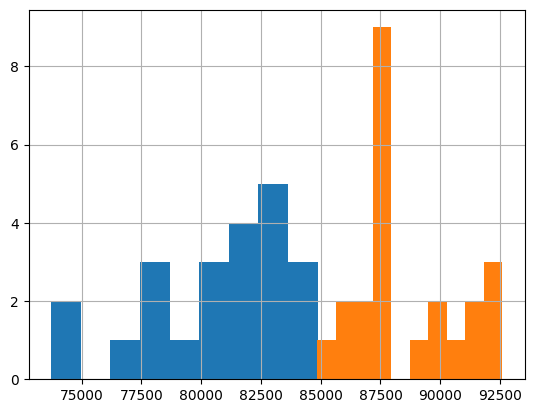

In [127]:
df_piv_daily[df_piv_daily['group'] == 'A']['average_bill'].hist()
df_piv_daily[df_piv_daily['group'] == 'B']['average_bill'].hist()

- проверка нулевой гипотезы при помощи Т-теста

In [129]:
a = 0.05                           
                             
results = stats.ttest_ind(
    df_piv_daily[df_piv_daily['group'] == 'A']['average_bill'],
    df_piv_daily[df_piv_daily['group'] == 'B']['average_bill'],
    equal_var = True)

print(results)

TtestResult(statistic=np.float64(-9.609060180794826), pvalue=np.float64(2.2523650297552113e-12), df=np.float64(44.0))


#### ВЫВОД: Отвергаем нулевую гипотезу: средние чеки не равны.

### ОБЩИЕ ВЫВОДЫ:
### Несмотря на то что конверсия группы B ниже, статистической значимости в конверсии не достигнуто, соответственно, считать конверсии разными оснований нет. Зато средний чек группы B значительно выше среднего чека группы A. Статистическая значимость достигнута. Вариант сайта B приносит значимо больше выручки, чем вариант сайта A. Рекомендуем признать, что вариант B лучше, чем вариант A!